<font color='blue' size=5><b>Комментарий ревьюера</b></font>

<font color='blue'>Привет, Павел! Меня зовут Павел Григорьев, и я буду проверять этот проект.<br>Моя основная цель - не указать на совершённые тобой ошибки, а поделиться своим опытом и помочь тебе совершенствоваться как профессионалу.<br>Спасибо за проделанную работу! Предлагаю общаться на «ты».</font>
<details>
	<summary><u>Инструкция по организационным мометнам (кликабельно)</u></summary>
<font color='blue'>Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</font>


---


<font color='blue'>синий текст - просто текст комментария</font>

<font color='green'>✔️ и зеленый текст - все отлично</font>

<font color='orange'>⚠️ и оранжевый текст - сделано все правильно, однако есть рекомендации, на что стоит обратить внимание</font>

<font color='red'>❌ и красный текст - есть недочеты</font>


</details>    
    </br>
<font color='blue'>Пожалуйста, не удаляй мои комментарии в случае возврата работы, так будет проще разобраться, какие были недочеты, а также сразу увидеть исправленное. </font>

Ответы на мои комментарии лучше тоже помечать.
Например: <font color='purple'><b>Комментарий студента</b></font>

<font color='blue'><b>Давай смотреть, что получилось!</b></font>


# Определение стоимости автомобилей - проект сдан

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Иморт библиотек:

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.compose import make_column_transformer
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
RANDOM_STATE = 12345
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

Напишем класс для оценки таймингов

In [2]:
class TimerError(Exception):  #5
    """Пользовательское исключение, используемое для сообщения об ошибках при использовании класса Timer"""


class Timer: #9

    def __init__(self):
        self._start_time = None


    def start(self):
        """Запуск нового таймера"""

        if self._start_time is not None:
            raise TimerError(f"Таймер уже работает. Используйте .stop() чтобы его остановить")

        self._start_time = time.perf_counter()


    def stop(self):
        """Отстановить таймер и сообщить о времени вычисления"""

        if self._start_time is None:
            raise TimerError(f"Таймер не работает. Используйте .start() для его запуска")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Вычисление заняло {elapsed_time:0.4f} секунд")

Импорт датасета

In [3]:
try:
    df = pd.read_csv('autos.csv')
    print('датасет загружен локально')
except:
    df = pd.read_csv('/datasets/autos.csv')
    print('датасет загружен с сервера')

датасет загружен локально


## Подготовка данных

### Посмотрим на данные

In [4]:
df[:5]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Данные загружены корректно, первичный осмотр проведен.</font>

Распишем столбцы и поймем какие в них данные и нужны ли они нам для модели:

DateCrawled - этот признак не несет никакой пользы для модели
Price - это нужный количественный признак
VehicleType - это нужный категориальный признак
RegistrationYear - это нужный категориальный признак
Gearbox - это нужный категориальный признак
Power - это нужный количественный признак
Model - это нужный категориальный признак
Kilometer - это нужный количественный признак
RegistrationMonth - это нужный категориальный признак
FuelType - нужный категориальный признак
Brand - нужный категориальный признак
Repaired - нужный категориальный признак
DateCreated - этот признак не несет никакой пользы для модели
NumberOfPictures - это столбец с нулями - лишний признак
PostalCode - этот признак не несет никакой пользы для модели
LastSeen - этот признак не несет никакой пользы для модели

В итоге можем сразу дропнуть столбцы DateCrawled, DateCreated, PostalCode и LastSeen

In [5]:
df = df.drop(['DateCreated', 'DateCrawled', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

Посмотрим на типы оставшихся столбцов

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


Создадим 2 списка с названиями столбцов количественных и категориальных данных для построения нужных графиков.
предварительно приведем названия столбцов в нормальный вид

In [7]:
df[:0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired


In [8]:
# для начала приведем столбцы к нормальной записи:
df.columns = df.columns.str.lower()
df = df.rename(columns = {'vehicletype':'vehicle_type','registrationyear':'registration_year', 'registrationmonth': 'registration_month', 'numberofpictures': 'number_of_pictures'})

# список категориальных признаков
cat_signs_list = ['vehicle_type', 'registration_year', 'registration_month', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']
cat_signs = df[cat_signs_list]
# список количественных признаков
quant_signs_list = ['price', 'power', 'kilometer']
quant_signs = df[quant_signs_list]

In [9]:
# Напишем функию для анализа количественных данных
def df_info(data):
    data.info()
    display(data.describe())
    print('Процент пропусков')
    display(pd.DataFrame(round(data.isna().mean()*100,)))
    #plt.figure(figsize = (20,20))
    #plt.subplot(3, 3, 1)
    for i in data.columns:
        sns.set(rc={'figure.figsize':(16,5)})
        sns.histplot(data=data, x=i)
        plt.show()
        sns.set(rc={'figure.figsize':(16,2)})
        sns.boxplot(data=data, x=i)
        plt.show()
    sns.set(rc={'figure.figsize':(4,4)})
    display(sns.heatmap((data).corr(), annot = True, vmin=-1, vmax=1, center= 0)) # значения корреляции через хитмэп

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   price      354369 non-null  int64
 1   power      354369 non-null  int64
 2   kilometer  354369 non-null  int64
dtypes: int64(3)
memory usage: 8.1 MB


,price,power,kilometer
count,354369.000000,354369.000000,354369.000000
mean,4416.656776,110.094337,128211.172535
std,4514.158514,189.850405,37905.341530
min,0.000000,0.000000,5000.000000
25%,1050.000000,69.000000,125000.000000
50%,2700.000000,105.000000,150000.000000
75%,6400.000000,143.000000,150000.000000
max,20000.000000,20000.000000,150000.000000


Процент пропусков


,0
price,0.0
power,0.0
kilometer,0.0


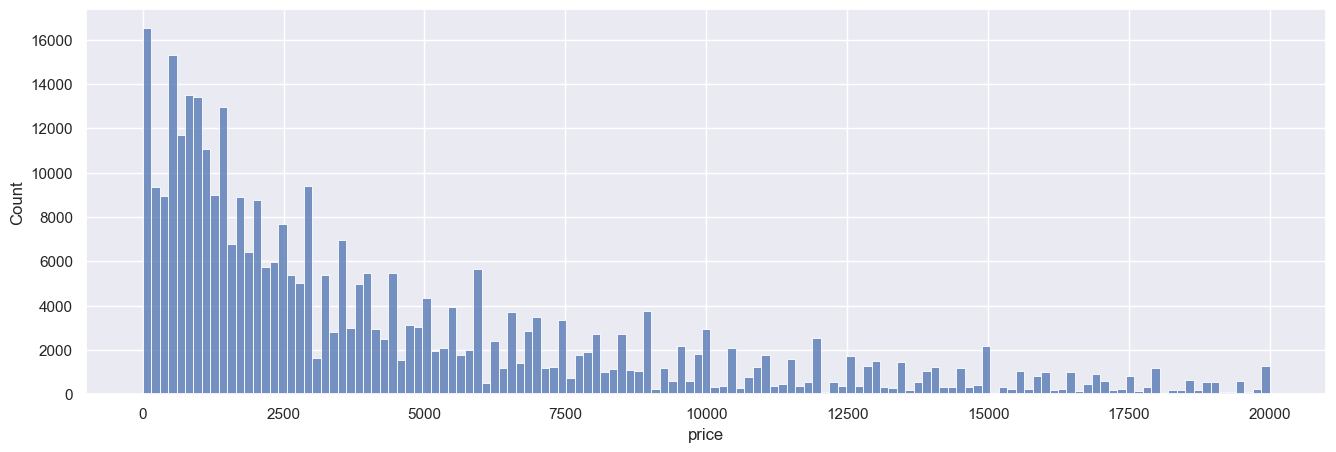

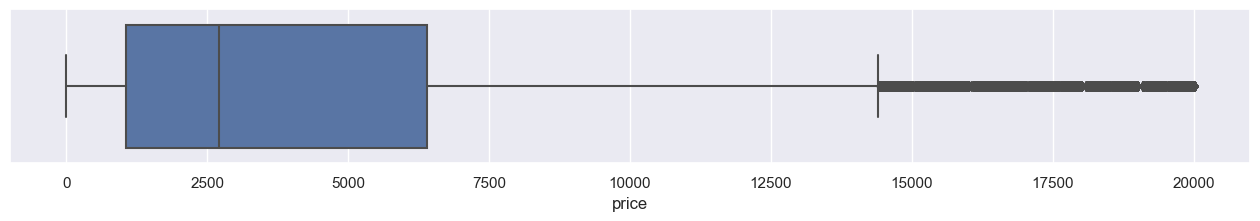

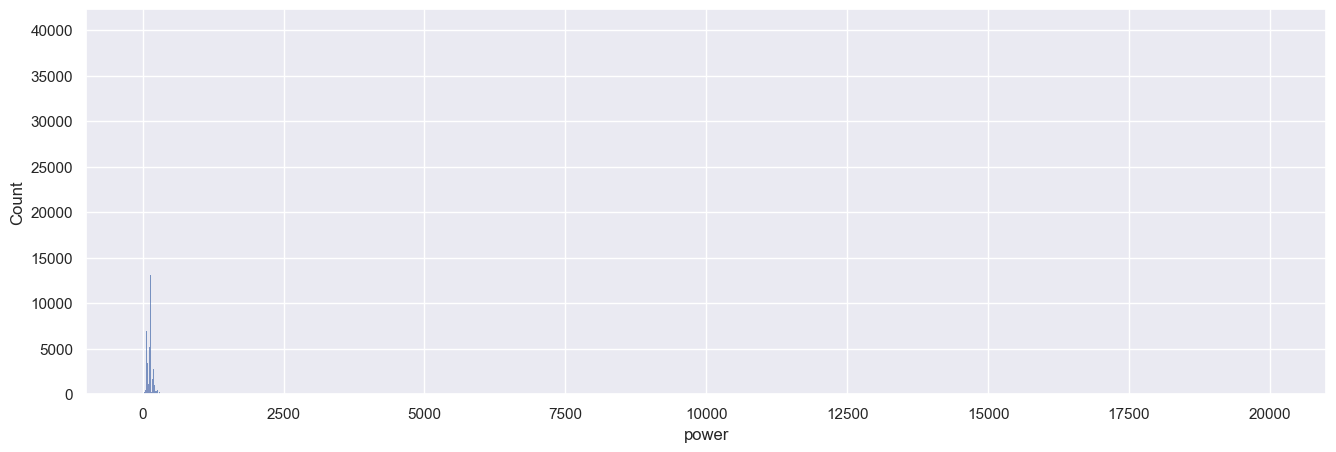

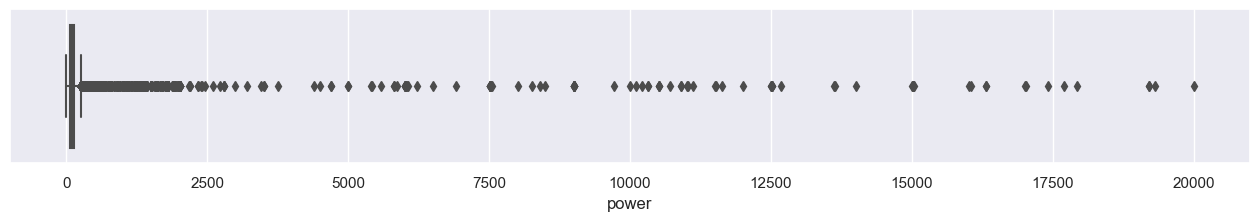

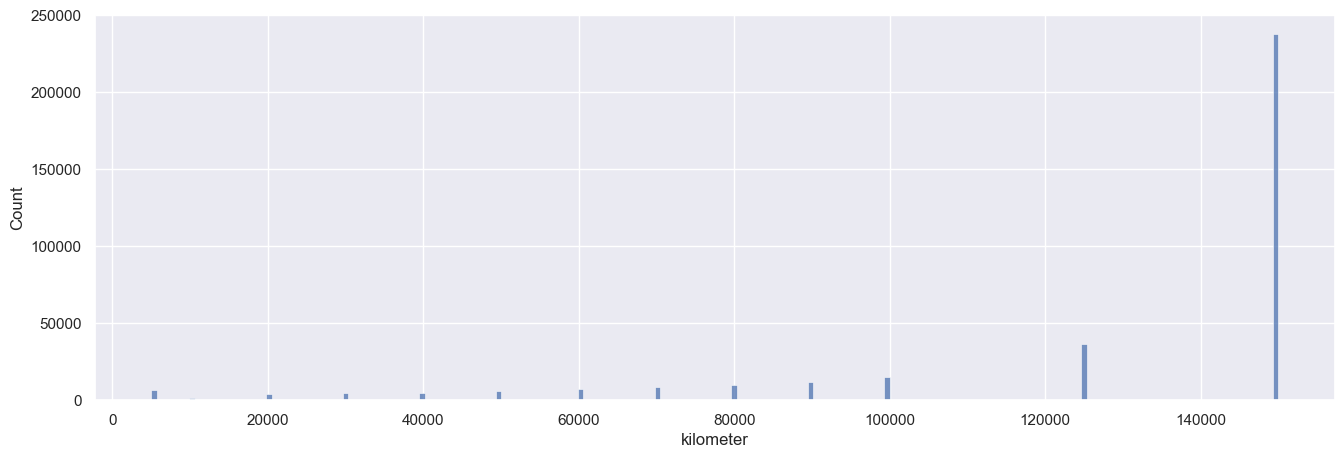

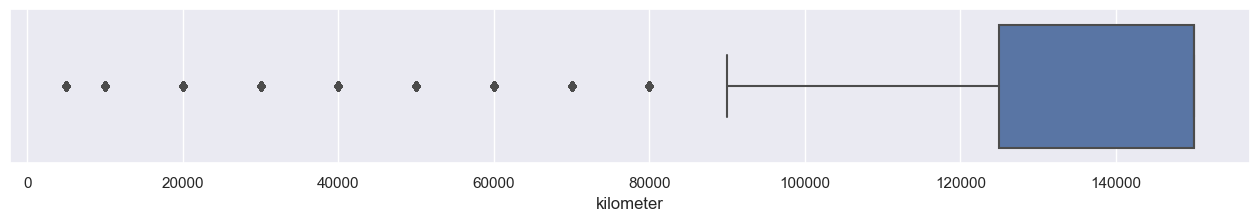

<AxesSubplot: >

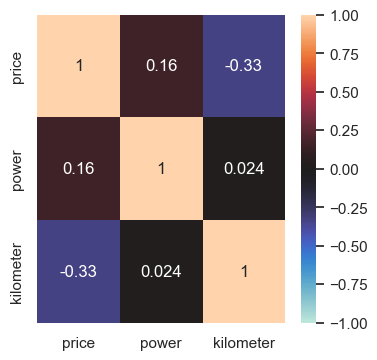

In [10]:
df_info(quant_signs)

Оценим увиденное:
Price - Нормально распределен, пропусков нет. но нужно ограничить нижний предел.
Power - тут есть аномалии до 45 л.c. и после 234 л.c. недобходимо удалить данные вне этого диапазона

In [11]:
df = df.query('price > 300').reset_index(drop=True)
df = df[(df['power'] > 45) & (df['power'] < 234)].reset_index(drop=True)

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>👍</font>

Kilometer - Большинство машин с пробегом более 150к но в этом ничего удивительного в принципе нет.
По корреляции в количественных столбцах все в порядке.

Проанализируем категориальные данные

In [12]:
# Напишем функию для анализа количественных данных
def df_info_cat(data):
    data.info()
    display(data.describe())
    print('Процент пропусков')
    display(pd.DataFrame(round(data.isna().mean()*100,)))
    for i in data.columns:
        sns.set(rc={'figure.figsize':(16,5)})
        sns.histplot(data=data, x=i)
        plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   vehicle_type        316879 non-null  object
 1   registration_year   354369 non-null  int64 
 2   registration_month  354369 non-null  int64 
 3   gearbox             334536 non-null  object
 4   model               334664 non-null  object
 5   fueltype            321474 non-null  object
 6   brand               354369 non-null  object
 7   repaired            283215 non-null  object
dtypes: int64(2), object(6)
memory usage: 21.6+ MB


,registration_year,registration_month
count,354369.000000,354369.000000
mean,2004.234448,5.714645
std,90.227958,3.726421
min,1000.000000,0.000000
25%,1999.000000,3.000000
50%,2003.000000,6.000000
75%,2008.000000,9.000000
max,9999.000000,12.000000


Процент пропусков


,0
vehicle_type,11.0
registration_year,0.0
registration_month,0.0
gearbox,6.0
model,6.0
fueltype,9.0
brand,0.0
repaired,20.0


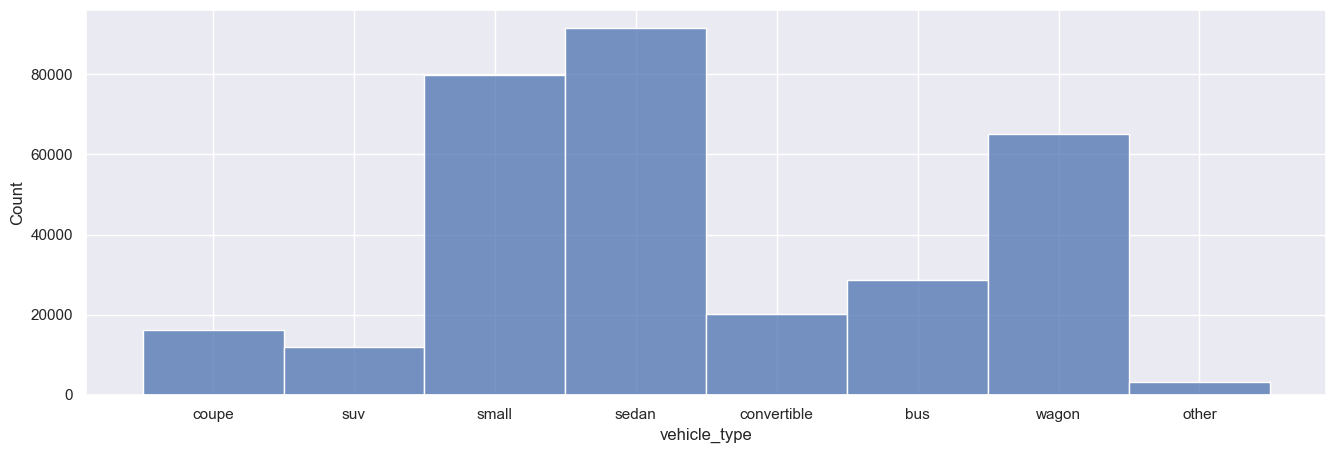

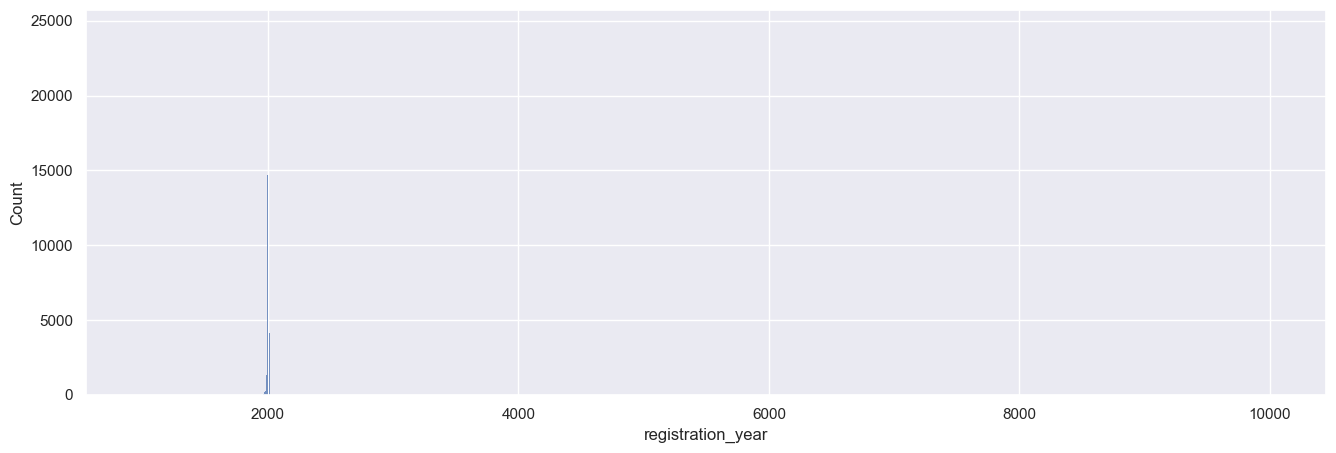

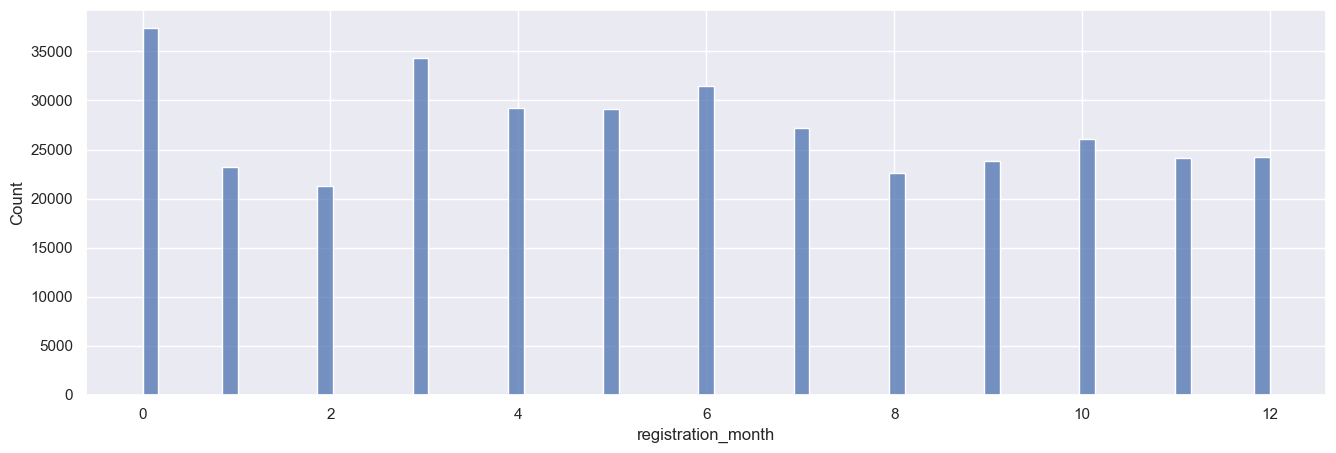

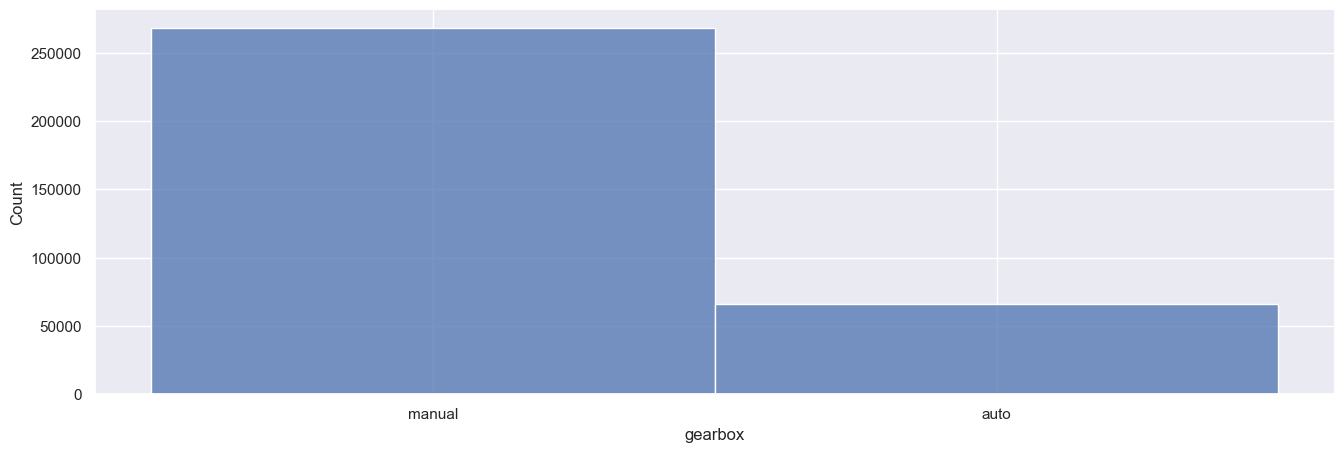

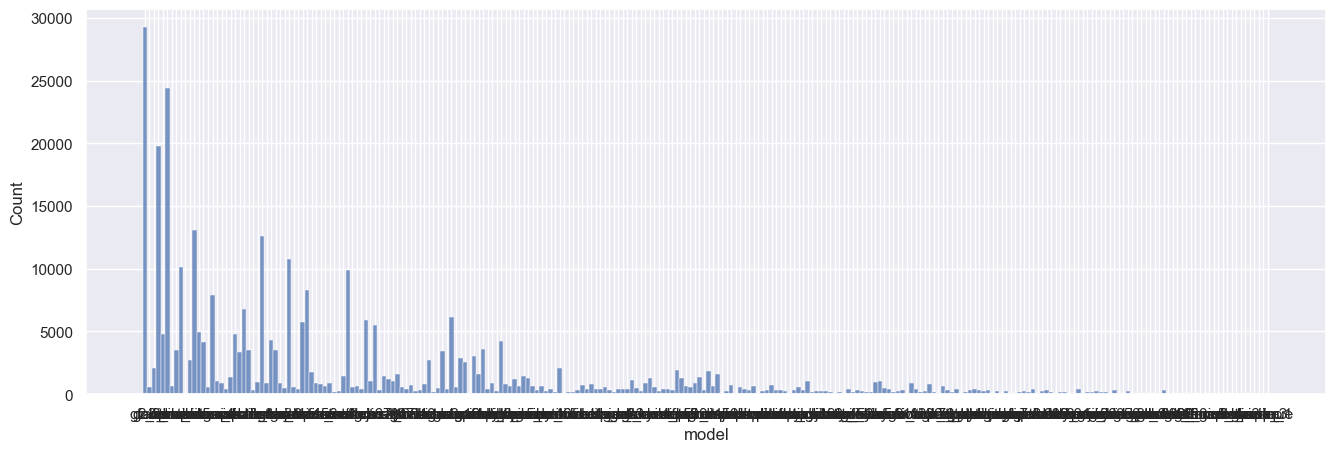

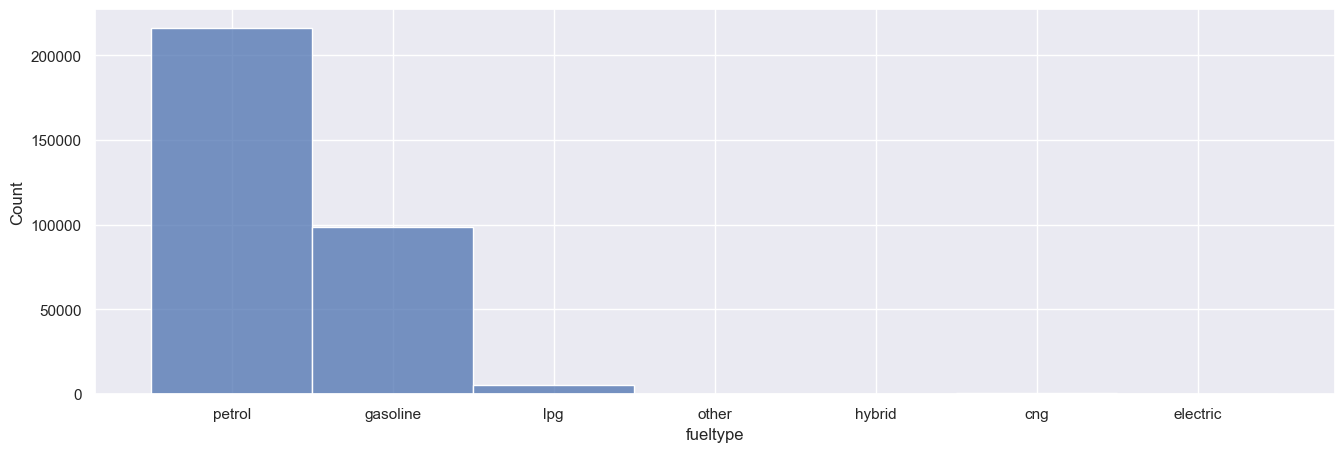

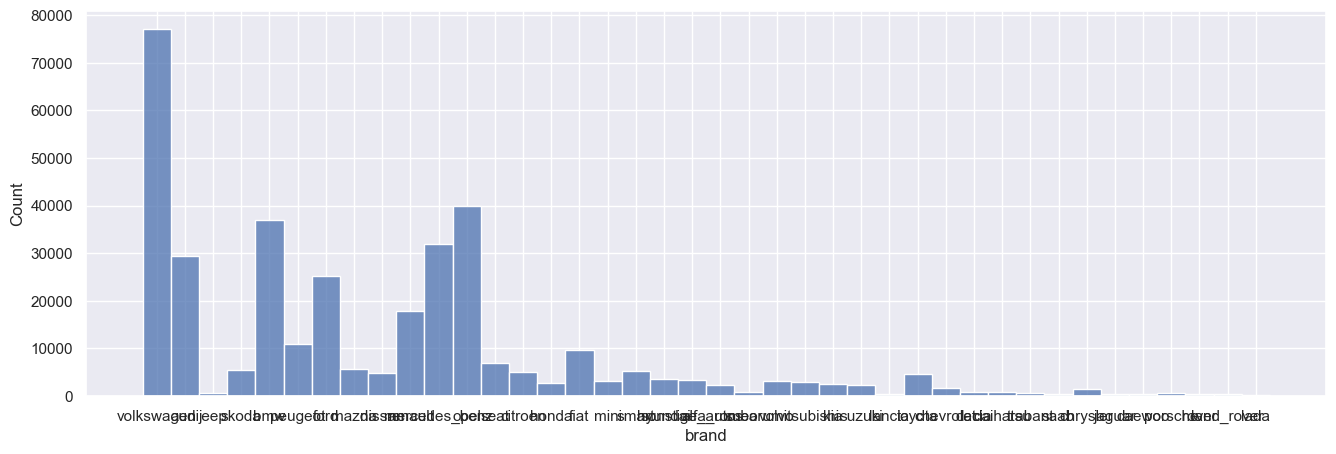

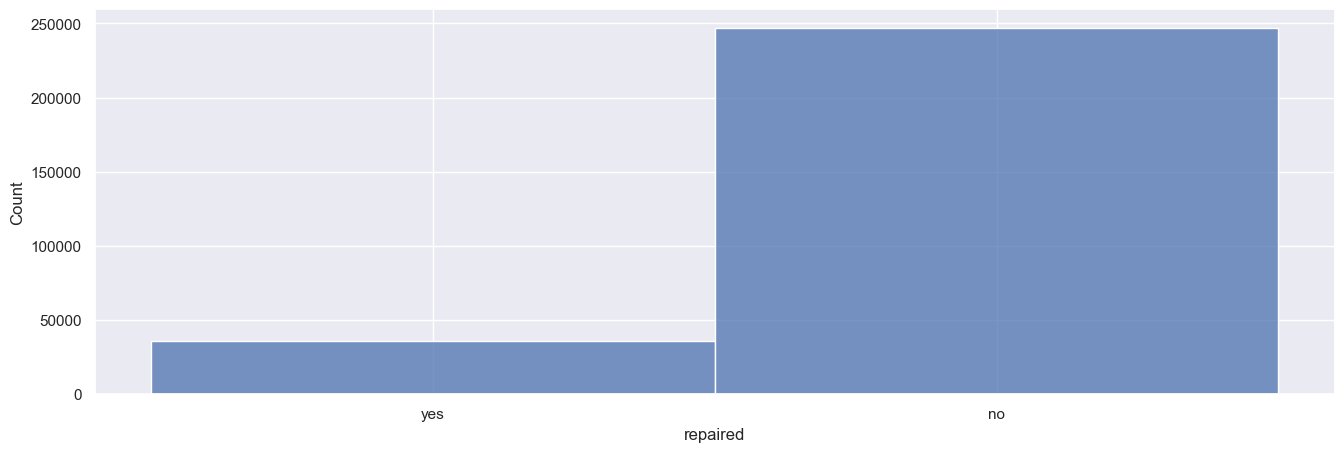

In [13]:
df_info_cat(cat_signs)

In [14]:
df.registration_month.value_counts()

3     29224
6     26357
4     24680
5     24539
7     22615
10    21956
12    20258
11    20159
9     19995
1     19045
8     18965
2     18021
0     16753
Name: registration_month, dtype: int64

In [15]:
# Необходимо удалить 0-е значения в 0-м месяце так как это явная ошибка
df = df[df['registration_month'] > 0]

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'>  Обрати внимание на уникальные значения в "registration_month"</font>

#### поправил

Видим, что есть аномалии в поле year, а также анкеты были скачаны в марте и апреле 2016 года, а значит есть смысл удалить все строки с регистрацией после 2016 года

In [16]:
df = df[(df['registration_year'] > 1949) & (df['registration_year'] < 2017)]

#### поправил

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Обрати внимание на даты в DateCrawled в сравнении с RegistrationYear</font>

Осталось обработать пропуски и удалить явные дубликаты.
Заменим пропуски в категориальных данных значением other.

In [17]:
df = df.fillna('other')

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Пропуски заполнены достаточно безопасно.
</font>

In [18]:
df = df.reset_index(drop=True)

In [19]:
df[:1]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fueltype,brand,repaired
0,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes


In [20]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

### ВЫВОД
Проведена подготовка данных: аномалии выявлены и удалены, заменены пропуски, удалены дубликаты и неинформативные признаки

## Обучение моделей

### Разделим выборки

In [56]:
features_train, features_valid, target_train, target_valid = train_test_split(
    df.drop('price', axis=1), df.price, test_size=0.4, random_state = RANDOM_STATE)

In [57]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid,
                                                                            test_size=0.5,
                                                                            random_state = RANDOM_STATE)

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Здорово , что у нас есть три выборки!</font>

### Обучим скейлры ORDINAL и SCALER

In [58]:
features_train

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fueltype,brand,repaired
84105,bus,2004,manual,114,other,150000,10,gasoline,opel,other
32700,bus,2007,auto,109,b_klasse,125000,9,gasoline,mercedes_benz,no
159106,small,2002,manual,75,golf,150000,11,petrol,volkswagen,no
29813,wagon,2008,manual,116,vito,150000,3,gasoline,mercedes_benz,no
173648,small,2005,manual,68,fiesta,150000,11,gasoline,ford,yes
...,...,...,...,...,...,...,...,...,...,...
85412,small,2010,manual,73,c3,50000,10,petrol,citroen,no
133249,coupe,1993,auto,150,other,150000,4,lpg,mercedes_benz,no
130333,small,1999,manual,75,2_reihe,150000,6,petrol,peugeot,no
77285,suv,2009,auto,205,other,50000,7,petrol,sonstige_autos,no


In [61]:
# Ordinal Encoder and Sacler
obj_list = ['vehicle_type', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']
num_list = ['registration_year', 'power', 'kilometer', 'registration_month']

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(features_train[obj_list])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

### Напишем функцию трансформации для выборок

In [62]:
def ordinal(dt):
    dt = dt.reset_index(drop=True)
    encoder_data = pd.DataFrame(encoder.transform(dt[obj_list]))
    dt_ordinal = dt[num_list].join(encoder_data)
    return dt_ordinal

### Применем трансформацию

In [63]:
features_train = ordinal(features_train)

scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)

features_valid = ordinal(features_valid)
features_valid = scaler.transform(features_valid)

features_test = ordinal(features_test)
features_test = scaler.transform(features_test)

features_train.shape, features_valid.shape, features_test.shape

((142169, 10), (47390, 10), (47390, 10))

In [27]:
features_train

array([[ 0.12768212, -0.08635748,  0.61019591, ..., -1.43591279,
         0.24446825,  1.1207031 ],
       [ 0.60879631, -0.20176113, -0.06449181, ..., -1.43591279,
        -0.05546104, -0.48106263],
       [-0.19306068, -0.98650599,  0.61019591, ...,  0.7286579 ,
         1.29422078, -0.48106263],
       ...,
       [-0.67417488, -0.98650599,  0.61019591, ...,  0.7286579 ,
         0.31945057, -0.48106263],
       [ 0.92953911,  2.01398905, -2.08855497, ...,  0.7286579 ,
         0.91930916, -0.48106263],
       [ 0.12768212, -0.64029502, -1.54880479, ...,  0.7286579 ,
         0.24446825, -0.48106263]])

### Напишем функцию рандомного Greedsearch для быстрого подбора гиперпараметров

In [28]:
# gridsearch с таймингом с вариантом рандомного или точного поиска
def gs_model(model, param_grid, model_data_name, X, y):
    gs = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        scoring='neg_root_mean_squared_error',
        n_jobs=14,
        random_state=RANDOM_STATE
    )
    gs.fit(X, y)
    # лучшее значение RMSE на кросс-валидации
    print(f'best_score: {gs.best_score_ * -1}')
    globals()[f"rmse_{model_data_name}"]= gs.best_score_* -1
    globals()[f"time_{model_data_name}"]= gs.refit_time_
    # лучшие гиперпараметры
    print(f'best_params: {gs.best_params_}')
    print(f'best_time: {gs.refit_time_}')
    return

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> Время обучения модели нужно измерить без подбора гиперпараметров. Сетка параметров у моделей разная и сравнивать время их перебора некорректно.</font>

#### поправил

<font color='blue'><b>Комментарий ревьюера : </b></font>\
<font color='blue'>Время обучения модели с лучшими параметрами на всех данных (в конце подбора) можно вытащить как  `gs.refit_time_`</font>

### Обучим модель LGBRegressor на обучающей выборке

In [29]:
model_lgb = lgb.LGBMRegressor()

In [30]:
# словарь с гиперпараметрами и значениями, которые хотим перебрать
parameters = {
    'n_estimators': np.arange(1, 1000, 10),
    'max_depth': np.arange(1, 10, 1),
    'learning_rate': np.arange(0.01, 1, 0.01)}

#### Найдем примерные лучшие гиперпараметры для LGBRegressor

In [31]:
gs_model(model_lgb, parameters, 'lgb_train', features_train, target_train)

best_score: 1509.680042921857
best_params: {'n_estimators': 661, 'max_depth': 8, 'learning_rate': 0.31}
best_time: 19.65553903579712


<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> Модели основанные на деревьях (все модели в этом проекте) , могут работать с порядковым кодированием категорий (OrdinalEncoding). OHE сильно раздувает размерность данных, что сказывается на вычислительной нагрузке (времени).</font>

#### поправил

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'>LGBM может сам кодировать категории, если их перевести в тип данных 'category', но эта кодровка занимает дополнительное время. Если кодировать OE, то получатся быстрее.</font>

In [32]:
rmse_lgb_train, time_lgb_train

(1509.680042921857, 19.65553903579712)

In [33]:
%%time
# Проверим модель на валидационной выборке
model_lgb_true = lgb.LGBMRegressor(learning_rate=0.31, max_depth=8, n_estimators=661)
model_lgb_true.fit(features_train, target_train)
probs_lgb = model_lgb_true.predict(features_valid)
rmse_lgb_valid = mean_squared_error(probs_lgb, target_valid, squared=False)
rmse_lgb_valid

CPU times: user 45.2 s, sys: 16.3 s, total: 1min 1s
Wall time: 32.5 s


1491.8726305132707

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> RMSE можно получить передав параметр `squared= False` в `mean_squared_error`</font>

#### поправил

#### Вывод по бустингу LGBM Regressor
Для экономии времени мы использовали рандомный гридсерч и подбирали гиперпараметры для бустинга
В итоге подбор и обучение модели заняли 16.39 sec. RMSE - 1509
На валидационной выборке результат тоже хороший - 1491

### Обучим модель Random Forest Regression на обучающей выборке

In [34]:
# попробуем не очень большое кол-во деревьев и рандом, так как эта модель будет слишком долгой если будем крутить до 1000 с шагом 10
model_rndforest = RandomForestRegressor()
# словарь с гиперпараметрами и значениями, которые хотим перебрать
parameters_rdf = {
    'n_estimators': np.arange(1, 300, 20),
    'max_depth': np.arange(1, 10, 2)}

In [35]:
gs_model(model_rndforest, parameters_rdf, 'rf_train', features_train, target_train)

best_score: 2030.397571069628
best_params: {'n_estimators': 261, 'max_depth': 7}
best_time: 29.130393028259277


In [36]:
%%time
# Проверим модель на валидационной выборке
model_rndforest_true = RandomForestRegressor(n_estimators=21, max_depth=9)
model_rndforest_true.fit(features_train, target_train)
probs_rnd_val = model_rndforest_true.predict(features_valid)
mean_squared_error(probs_rnd_val, target_valid, squared=False)

CPU times: user 2.86 s, sys: 7.13 ms, total: 2.87 s
Wall time: 2.87 s


1857.4447821614085

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> CatBoost может сам кодировать категории из типа данных 'object' и 'category', но эта кодровка занимает дополнительное время. Если кодировать OE, то получатся быстрее.</font>

#### поправил

#### Вывод
С лесом в этой задаче мы будем очень долго искать минимальную метрику, так как даже на 100 деревьев тайминг 166 секунды даже с рандомным гридсерчем.
а результат слишком низкий по сравнению с бустингм от Майкрософт - 1892
Обучение и предсказание на валидационной модели заняло 16.9 секунд. показатель 1894

### Обучим модель Catboost на обучающей выборке (заценим бустинг от Яда)

In [37]:
modelcat = CatBoostRegressor()
parameters_cat = {
    'iterations': np.arange(1, 1000, 10),
    'depth': np.arange(1, 10, 1),
    'learning_rate': np.arange(0.01, 1, 0.01)}
gs_model(modelcat, parameters_cat, 'catboost_train', features_train, target_train)

0:	learn: 3507.7810933	total: 72.1ms	remaining: 15.1s
1:	learn: 3191.4419944	total: 82.3ms	remaining: 8.6s
2:	learn: 3077.7724017	total: 90.2ms	remaining: 6.25s
3:	learn: 3002.6444831	total: 102ms	remaining: 5.26s
4:	learn: 2929.2507298	total: 117ms	remaining: 4.83s
5:	learn: 2852.2349447	total: 127ms	remaining: 4.34s
6:	learn: 2769.0025151	total: 136ms	remaining: 3.96s
7:	learn: 2725.5711347	total: 147ms	remaining: 3.74s
8:	learn: 2686.4408154	total: 176ms	remaining: 3.95s
9:	learn: 2649.1727796	total: 183ms	remaining: 3.68s
10:	learn: 2614.9286384	total: 246ms	remaining: 4.47s
11:	learn: 2578.7722888	total: 300ms	remaining: 4.97s
12:	learn: 2552.1205911	total: 347ms	remaining: 5.29s
13:	learn: 2512.6358430	total: 439ms	remaining: 6.18s
14:	learn: 2489.8033742	total: 449ms	remaining: 5.86s
15:	learn: 2469.2973301	total: 471ms	remaining: 5.74s
16:	learn: 2449.7583870	total: 488ms	remaining: 5.57s
17:	learn: 2423.2014880	total: 495ms	remaining: 5.31s
18:	learn: 2407.9921410	total: 502ms

In [38]:
rmse_catboost_train, time_catboost_train

(1518.3578587774405, 4.489620923995972)

In [39]:
%%time
# Проверим модель на валидационной выборке
model_cat_true = CatBoostRegressor(learning_rate=0.57, iterations=831, depth=5)
model_cat_true.fit(features_train, target_train)
probs_cat = model_cat_true.predict(features_valid)
rmse_catboost_valid = mean_squared_error(probs_cat, target_valid, squared=False)
rmse_catboost_valid

0:	learn: 3118.1455626	total: 9.82ms	remaining: 8.15s
1:	learn: 2560.7660593	total: 15.8ms	remaining: 6.56s
2:	learn: 2283.8722092	total: 22.4ms	remaining: 6.18s
3:	learn: 2152.3413253	total: 28.2ms	remaining: 5.83s
4:	learn: 2079.9215629	total: 36ms	remaining: 5.94s
5:	learn: 2024.5714390	total: 40.8ms	remaining: 5.61s
6:	learn: 1964.4936182	total: 46.1ms	remaining: 5.42s
7:	learn: 1927.2599858	total: 51.3ms	remaining: 5.27s
8:	learn: 1897.1545476	total: 57.4ms	remaining: 5.24s
9:	learn: 1876.8890691	total: 63.8ms	remaining: 5.24s
10:	learn: 1864.3986537	total: 70ms	remaining: 5.22s
11:	learn: 1841.6436963	total: 75.1ms	remaining: 5.12s
12:	learn: 1816.7579860	total: 80.5ms	remaining: 5.07s
13:	learn: 1803.6184581	total: 85.8ms	remaining: 5.01s
14:	learn: 1793.5155904	total: 92.9ms	remaining: 5.05s
15:	learn: 1778.7997981	total: 97.9ms	remaining: 4.99s
16:	learn: 1771.2703858	total: 103ms	remaining: 4.95s
17:	learn: 1760.9151776	total: 109ms	remaining: 4.94s
18:	learn: 1755.8803897	to

1504.9103721690535

#### Вывод по бустингу CatBoost
Для экономии времени мы использовали рандомный гридсерч и подбирали гиперпараметры для бустинга
В итоге подбор и обучение модели заняли всего 5 секунд!. Это отличный результат с показателем RMSE: 1518. (всего на 9 меньше чем у LGB)
На валидационной выборке результат тоже хороший - 1504

## Анализ моделей

Посмотрим как ведут себя обе модели бустинга на тестовой выборке:

In [40]:
%%time
probs_lgb_test = model_lgb_true.predict(features_test)
rmse_lgb_test = mean_squared_error(probs_lgb_test, target_test, squared=False)
rmse_lgb_test

CPU times: user 1.46 s, sys: 8.22 ms, total: 1.47 s
Wall time: 185 ms


1494.9559332730075

In [41]:
%%time
probs_cat_test = model_cat_true.predict(features_test)
rmse_catboost_test = mean_squared_error(probs_cat_test, target_test, squared=False)
rmse_catboost_test

CPU times: user 41.8 ms, sys: 5.84 ms, total: 47.6 ms
Wall time: 8.17 ms


1499.5132588538925

In [42]:
# создадим таблицу с результатами
d = {
    'Model': ['LightGBM', 'CatBoost'],
    'RMSE train': [rmse_lgb_train, rmse_catboost_train],
    'RMSE valid': [rmse_lgb_valid, rmse_catboost_valid],
    'RMSE test': [rmse_lgb_test, rmse_catboost_test],
    'gs_cv_time': [time_lgb_train, time_catboost_train]}
data = pd.DataFrame(data=d)
data

,Model,RMSE train,RMSE valid,RMSE test,gs_cv_time
0,LightGBM,1509.680043,1491.872631,1494.955933,19.655539
1,CatBoost,1518.357859,1504.910372,1499.513259,4.489621


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Отлично, что есть табличка результатов для сравнения.</font>

## Общий вывод:
- Проведена обрботка данных, d которой были удалены неинформативные признаки
- Выявлены аномалии, проведена работа с ними
- Заполнены пропуски
- Обучено 3 модели - 2 бустинга и 1 ансамбль леса
- В итоге модель lightGBM показала лучший результат по метрике RMSE
- Однако CatBoost  показала отличный результат в соотношении качество + скорость (на тестовой выборке RMSE gочти как и в
LGB однако Catboost сработал в 3 раза быстрее!
- учитывая все факторы, готов предложить модель бустинга CatBoost с подобранными гиперпараметрыми.

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Очень приятно видеть вывод в конце проекта! Приведены ответы на главные вопросы проекта.</font>

# Все исправил!

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>\
<font color='green'>Павел, хороший проект получился!
Большое спасибо за проделанную работу. Видно, что приложено много усилий.
</font>

<font color='blue'>Что нужно исправить:</font>
<ul><font color='red'>Используй кодирование категорий адекватное моделям.</font></ul>
<ul><font color='red'>Время обучения нужно измерить без подбора гиперпараметров.</font></ul>

<font color='blue'>Что можно сделать лучше:</font>
<font color='orange'>В работе я оставил несколько советов. Буду рад, если ты учтешь их.</font></ul>

<font color='blue'><b>Жду новую версию проекта :)</b></font>

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Мы, с коллегами, решили сделать небольшое дополнение к курсу по этому спринту.  https://colab.research.google.com/drive/1_gAMXcQKoCShB_l8FNtYEejMnosm9mvt?usp=sharing с примерами кодировки признаков разного уровня сложности. Посмотри, пожалуйста. Это может сильно помочь с предобработкой данных для моделей.</font>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей